In [1]:
# imports
import networks
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load model
encoder = networks.ResnetEncoder(50, False, ground=True)
encoder.load_state_dict(torch.load("weights/encoder.pth"))
depth_decoder = networks.DepthDecoder(
    encoder.num_ch_enc,
)
depth_decoder.load_state_dict(torch.load("weights/depth.pth"))

encoder = encoder.eval()
depth_decoder = depth_decoder.eval()

/opt/miniconda/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/opt/miniconda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


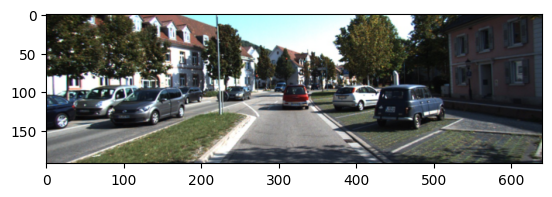

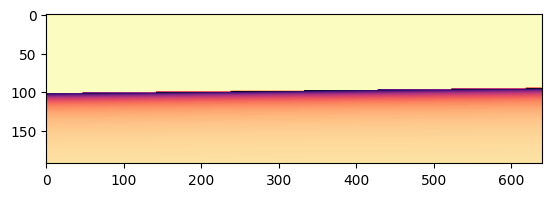

In [39]:
# load image and ground prior
image = cv2.cvtColor(cv2.imread("example/img.png"), cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

ground = cv2.imread("example/ground.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(ground, cmap="magma_r")
plt.show()

# convert to torch
image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float() / 255
ground = torch.from_numpy(ground)[None, None].float() / 255

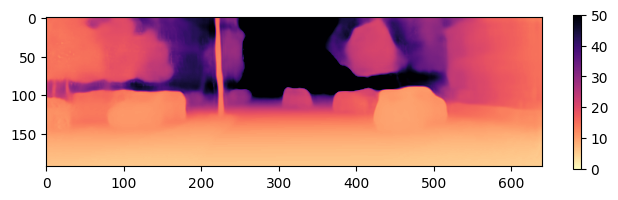

In [35]:
with torch.no_grad():
    inputs = torch.cat((image, ground), 1)
    output = depth_decoder(encoder(inputs))
    attention = output["ground_attn"]
    ground_meters = ground * 100 # unormalize ground depth to meters
    depth = output["depth"] * (1 - attention) + ground_meters * attention

plt.figure(figsize=(8, 2))
plt.imshow(depth[0, 0], vmax=50, cmap="magma_r")
plt.colorbar()
plt.show()